# **Capillary segmentation notebook**

The following script is used to build and train a 2D UNet architecture (https://arxiv.org/abs/1505.04597), which is the current state-of-the-art of Convolutional Neural Networks for image segmentation.

.
.
.

Last edited by Luca Marsilio 28/10/23

# Connect your Google Colab environment to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [ ]:
# Libraries for data handling and processing
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

# Libraries to build the CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from datetime import datetime
from dateutil.tz import gettz


import scipy
from scipy import signal
import cv2

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Clear any logs from previous runs
%rm -rf ./logs/

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Define working paths

In [ ]:
cwd = os.getcwd()
main_path = os.path.join(cwd, 'drive', 'MyDrive')
main_folder_path = os.path.join(main_path, 'Capillary_Images')
image_folder_path = os.path.join(main_folder_path, 'Original_Images_sn')
label_folder_path = os.path.join(main_folder_path, 'Segmentation_Labels_sn')
segm_model_folder_path = os.path.join(main_folder_path, 'Segmentation_Models')
segm_model_path = os.path.join(segm_model_folder_path, 'segm_model.h5')
print(image_folder_path)

/content/drive/MyDrive/Capillary_Images/Original_Images_sn


# Load Images

For loop across the two folders to load the images and segmentation labels, transform RGB capillary images into grayscale and stack the whole dataset in a numpy array

(201, 960, 1280)


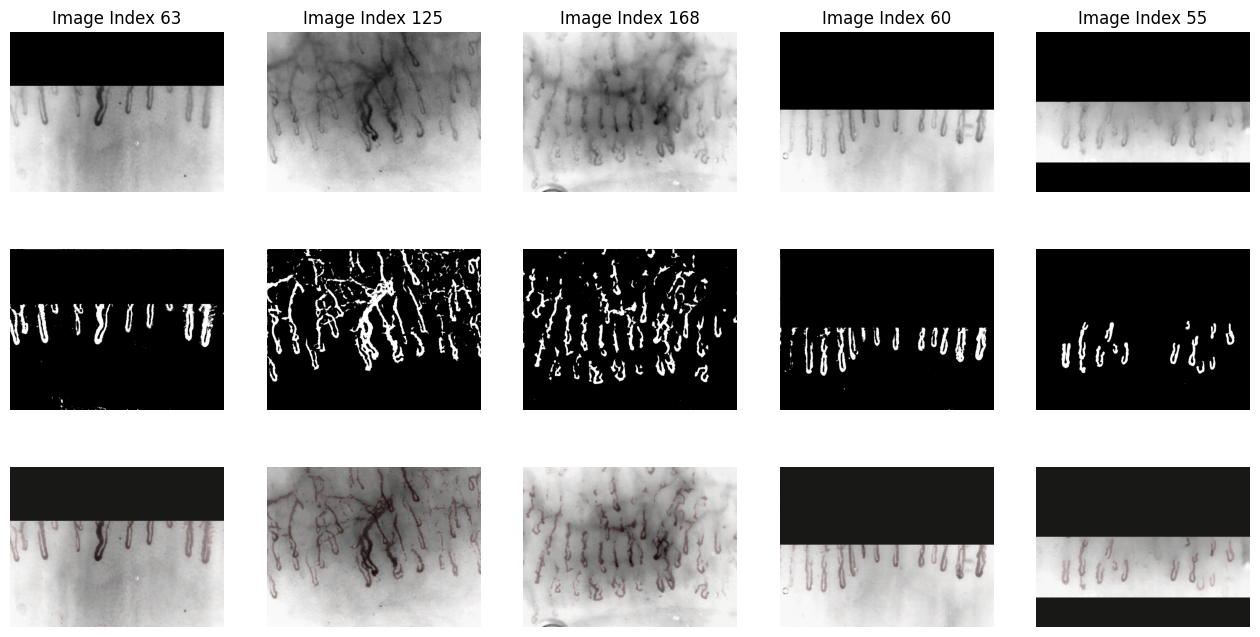

In [ ]:
# These lists will store the pixel values for all the dataset images
all_images = []
all_labels = []
i = 0;
# For  loop across all the images in the folder
for curr_image in os.listdir(image_folder_path):
    # Extract image code
    image_code = curr_image.split(sep='.')[0]
    # Find current image path
    curr_image_path = os.path.join(image_folder_path, curr_image)
    # Find matching label path (assuming that the currrent image and its corresponding label have the same name)
    curr_label_path = os.path.join(label_folder_path, f'{image_code}.png')

    # Load PNG Image and map from RGB to Gray Scale
    if os.path.exists(curr_image_path):
        curr_image = cv2.imread(curr_image_path, cv2.IMREAD_GRAYSCALE)
        curr_image = curr_image/255  #normalization
    else:
        raise NameError(f'Current image path does not exists: {curr_image_path}')

    # Load PNG Segmentation label
    if os.path.exists(curr_label_path):
        curr_label = cv2.imread(curr_label_path)
        curr_label = curr_label[:, :, 0]

        # !! WHEN YOU LOAD THE LABELS YOU SEE THAT BACKGROUND IS 0 WHILE CAPILLARIES 255 !!
        # !! THAT'S WHY I REMAP CAPILLARY VALUES TO BE = 1 !!
        index_capillaries_1 = np.where(curr_label > 50 )
        index_capillaries_0 = np.where(curr_label <= 50 )
        curr_label[index_capillaries_1] = 1
        curr_label[index_capillaries_0] = 0


        # !! WHY LABELS HAVE SHAPE (X, Y, 3)? CHECK IF IT IS OK TO CONSIDER JUST THE FIRST CHANNEL !!

        # !! WHY LABELS HAVE SHAPE (X, Y, 3)? CHECK IF IT IS OK TO CONSIDER JUST THE FIRST CHANNEL !!
        #curr_label = curr_label[:, :, 0]

        if len(np.unique(curr_label)) > 2:
            raise ValueError('Labels must have only 0 and 1 values !!!')
    else:
        raise NameError(f'Current label path does not exists: {curr_label_path}')

    # Resize both image and label to a fixed shape if needed
    # REMEMBER, WHEN YOU RESHAPE IMAGES, THEIR NEW SIZE MUST BE DIVISIBLE BY 32 !!
    # ...
    # ...

    # Preprocessing (if needed)
    # ...
    # ...

    # Add the following image and label to the lists
    all_images.append(curr_image)
    all_labels.append(curr_label)


# Generate two numpy arrays stacking along the first dimension (axis=0) each element of the two lists

stacked_images = np.concatenate([arr[np.newaxis] for arr in all_images], axis=0)
stacked_labels = np.concatenate([arr[np.newaxis] for arr in all_labels], axis=0)
print(stacked_images.shape)
# Add a new dimension along axis -1 for labels (mandatory to match dimensions)
stacked_labels = np.expand_dims(stacked_labels, axis=-1)

# Plot image and segmentation labels to check the result
# Create a 2x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(16, 8))

# Flatten the axs array for easy indexing
axs = axs.flatten()
# For loop
for i in range(5):
    # Select random index
    image_index = random.randint(0, stacked_images.shape[0] - 1)
    # Plot image
    axs[i].imshow(stacked_images[image_index], cmap='gray')
    axs[i].set_title(f'Image Index {image_index}')
    axs[i].axis('off')
    # Plot label
    axs[i + 5].imshow(stacked_labels[image_index], cmap='gray')
    axs[i + 5].axis('off')
    # Plot both overlapped
    axs[i + 10].imshow(stacked_images[image_index], cmap='gray', alpha=1)
    axs[i + 10].imshow(stacked_labels[image_index], cmap='Reds', alpha=0.1)
    axs[i + 10].axis('off')

plt.show()


In [ ]:
print(stacked_images.shape)
print(stacked_labels.shape)

#Preprocess the data

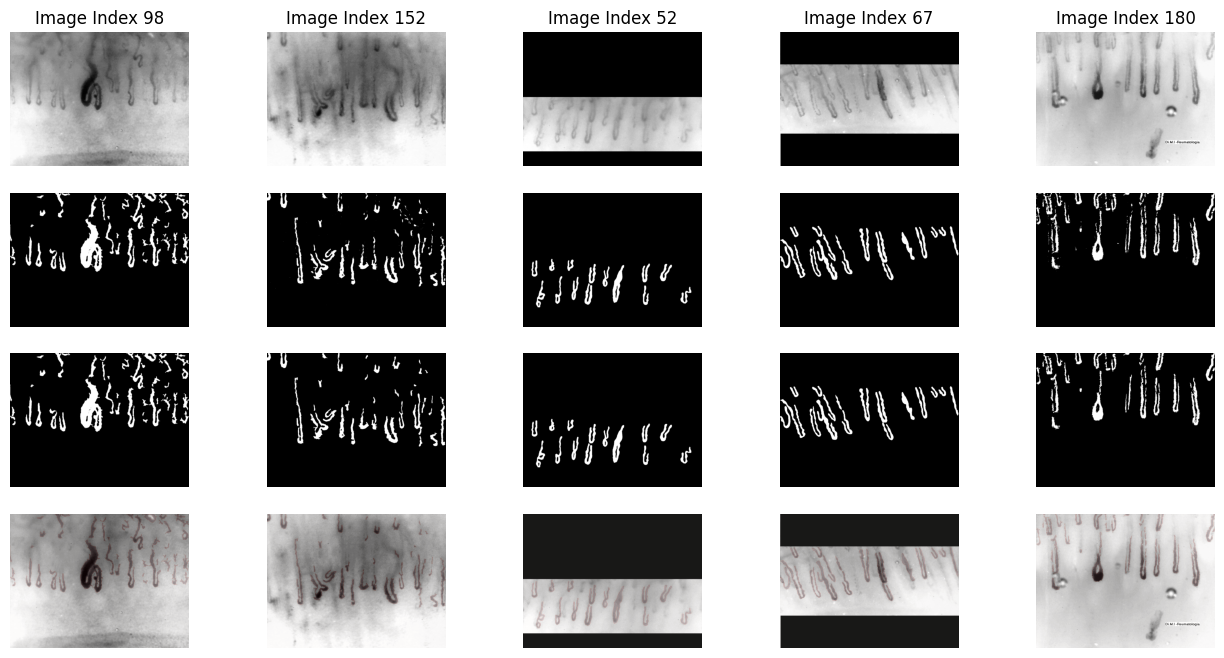

In [ ]:

def remove_small_white_regions(binary_image, min_area_threshold):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    result_image = np.copy(binary_image)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area_threshold:
            cv2.drawContours(result_image, [contour], 0, 0, thickness=cv2.FILLED)

    return result_image

# Variable contenant plusieurs images (shape : (187, 960, 1220))
images_variable = stacked_labels  # Remplacez cela par votre variable d'images

# Définir le seuil de superficie en fonction de vos besoins
min_area_threshold = 150  # Vous pouvez ajuster ce seuil selon vos besoins

# Créer une nouvelle variable pour stocker les images dénoisées
denoised_images_variable = []

# Itérer sur chaque image dans la variable
for i in range(images_variable.shape[0]):
    # Charger l'image binaire (assurez-vous que l'image est vraiment binaire)
    binary_image = images_variable[i]

    # Appliquer la fonction pour enlever les petites régions blanches
    result_image = remove_small_white_regions(binary_image, min_area_threshold)

    # Ajouter l'image dénoisée à la nouvelle variable
    denoised_images_variable.append(result_image)

# Convertir la liste en tableau numpy si nécessaire
stacked_labels_dn = np.array(denoised_images_variable)

# Maintenant, denoised_images_variable contient les images dénoisées


fig, axs = plt.subplots(4, 5, figsize=(16, 8))

# Flatten the axs array for easy indexing
axs = axs.flatten()
# For loop
for i in range(5):
    # Select random index
    image_index = random.randint(0, stacked_images.shape[0] - 1)
    # Plot image
    axs[i].imshow(stacked_images[image_index], cmap='gray')
    axs[i].set_title(f'Image Index {image_index}')
    axs[i].axis('off')
    # Plot label
    axs[i + 5].imshow(stacked_labels[image_index], cmap='gray')
    axs[i + 5].axis('off')
    # Plot label dn
    axs[i + 10].imshow(stacked_labels_dn[image_index], cmap='gray')
    axs[i + 10].axis('off')
    # Plot both overlapped
    axs[i + 15].imshow(stacked_images[image_index], cmap='gray', alpha=1)
    axs[i + 15].imshow(stacked_labels_dn[image_index], cmap='Reds', alpha=0.1)
    axs[i + 15].axis('off')

plt.show()

stacked_labels = stacked_labels_dn



# Build the UNet Architecture

In [ ]:
# Define the U-Net model
def UNet(input_shape, num_classes, depth=4, feature_maps_first=64, kernel_size=3, add_batch_normalization=False, add_dropout=False, dropout_rate=0.5):

    # Define input of the CNN
    temp_layer = keras.Input(shape=input_shape, name='Input_Layer')
    input_layer = temp_layer

    # List storing encoding layers
    encoding_layers = []

    # Encoding Path (Exract image features at different resolution)
    for layer in range(0, depth - 1):
        # Convolutional layers (extract features from images)
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Enc_1_{layer}')(temp_layer)
        if add_batch_normalization == True:
            temp_layer = layers.BatchNormalization(name=f'BatchNorm_{layer}')(temp_layer)
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Enc_2_{layer}')(temp_layer)
        if add_dropout==True and layer >= depth - 2:
            temp_layer = layers.Dropout(dropout_rate, name=f'Dropout_{layer}')(temp_layer)
        encoding_layers.append(temp_layer)
        # Max Pooling Layer (reduce image dimension)
        temp_layer = layers.MaxPooling2D(pool_size=(2, 2), name=f'MaxPool_{layer}')(temp_layer)

    # Bottleneck
    temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer + 1), kernel_size, activation='relu', padding='same', name=f'Conv_Btlnk_1_{layer + 1}')(temp_layer)
    if add_batch_normalization == True:
        temp_layer = layers.BatchNormalization(name=f'BatchNorm_Btlnk_{layer + 1}')(temp_layer)
    temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer + 1), kernel_size, activation='relu', padding='same', name=f'Conv_Btlnk_2_{layer + 1}')(temp_layer)
    if add_dropout == True:
        temp_layer = layers.Dropout(dropout_rate, name=f'Dropout_Btlnk_{layer + 1}')(temp_layer)

    # Decoding path
    for layer in range(depth - 2, -1, -1):
        temp_layer = layers.Conv2DTranspose(feature_maps_first * pow(2, layer), kernel_size=2, strides=(2, 2), activation='relu', padding='same', name=f'ConvTransp_{layer}')(temp_layer)
        temp_layer = layers.concatenate([encoding_layers[layer], temp_layer], axis=3, name=f'Concatenate_{layer}')
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Dec_1_{layer}')(temp_layer)
        temp_layer = layers.Conv2D(feature_maps_first * pow(2, layer), kernel_size, activation='relu', padding='same', name=f'Conv_Dec_2_{layer}')(temp_layer)

    # Output Layer
    temp_layer = layers.Conv2D(1, 1, activation='linear', padding='same', name='Final_Conv')(temp_layer)
    output_layer = layers.Activation('sigmoid', name='Sigmoid')(temp_layer)

    model = keras.Model(input_layer, output_layer)

    return model

# Define input shape and number of classes
input_shape = (stacked_images.shape[1], stacked_images.shape[2], 1)  # Adjust input shape as needed
num_classes = len(np.unique(stacked_labels[0, :, :]))  # Adjust for the number of segmentation classes

# Create the U-Net model
model = UNet(input_shape, num_classes, depth=3, feature_maps_first=8, add_batch_normalization=True, add_dropout=False)

# Print a summary of the model architecture
model.summary()

# plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 960, 1280, 1)]       0         []                            
                                                                                                  
 Conv_Enc_1_0 (Conv2D)       (None, 960, 1280, 8)         80        ['Input_Layer[0][0]']         
                                                                                                  
 BatchNorm_0 (BatchNormaliz  (None, 960, 1280, 8)         32        ['Conv_Enc_1_0[0][0]']        
 ation)                                                                                           
                                                                                                  
 Conv_Enc_2_0 (Conv2D)       (None, 960, 1280, 8)         584       ['BatchNorm_0[0][0]']   

# Compile and Train the model

In [ ]:
# Split the dataset into training and validation sets
#train_images, test_images, train_labels, test_labels = train_test_split(stacked_images, stacked_labels, test_size=0.2, random_state=42)
#To use binary cross entropy loss function (more suitable for the task) one-hot-encoding is required for the labels.


# Split data into training, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    stacked_images, stacked_labels, test_size=0.3, random_state=42
)

# Further split the temporary data into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42
)
# Print the sizes of the sets
print("Training set size:", len(train_images))
print("Validation set size:", len(val_images))
print("Test set size:", len(test_images))


Training set size: 140
Validation set size: 30
Test set size: 31


In [ ]:
#define weights at the beginning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate


def initialize_weights(model):
    for layer in model.layers:
        if isinstance(layer, (Conv2D, Conv2DTranspose)):
            # Set kernel initializer for convolutional layers
            layer.kernel_initializer = tf.keras.initializers.he_normal()

In [ ]:
#callbacks


# Define the checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_weights.h5',  # Specify the path to save the best weights
    monitor='val_loss',  # Monitor the validation loss
    save_best_only=True,  # Save only the best weights
    mode='min',  # The mode can be 'min' or 'max' depending on the monitored quantity
    verbose=1) # Optional: print additional information


# Your existing callbacks
cb = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=100, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=0),
    checkpoint_callback  # Add the ModelCheckpoint callback
]

In [ ]:
#data_augmentation
# Define the data augmentation transformations
datagen = ImageDataGenerator(
    #horizontal_flip=True,
    rotation_range=0.5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=(0.8, 1.2),
    #rescale=1./255  # Normalize pixel values between 0 and 1
)

# Create a generator for training data (images and labels)
train_generator = datagen.flow(
    x=np.expand_dims(train_images, axis=-1),
    y=np.expand_dims(train_labels, axis=-1),
    batch_size=8,
    seed=42,
)



Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 0.5163 - binary_accuracy: 0.8808 - false_negatives: 8756265.0000
Epoch 1: val_loss improved from inf to 0.46916, saving model to best_model_weights.h5
17/17 [==============================] - 39s 1s/step - loss: 0.5163 - binary_accuracy: 0.8808 - false_negatives: 8756265.0000 - val_loss: 0.4692 - val_binary_accuracy: 0.9403 - val_false_negatives: 1759375.0000 - lr: 0.0010
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 0.1960 - binary_accuracy: 0.9427 - false_negatives: 9289523.0000
Epoch 2: val_loss improved from 0.46916 to 0.29107, saving model to best_model_weights.h5
17/17 [==============================] - 14s 777ms/step - loss: 0.1960 - binary_accuracy: 0.9427 - false_negatives: 9289523.0000 - val_loss: 0.2911 - val_binary_accuracy: 0.9397 - val_false_negatives: 1778711.0000 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.1646 - binary_accuracy: 0.9421 - false_negatives: 9389225.0000
Epoch 3: val_loss improved from 0.29107 to 0.25185, saving model to best_model_weights.h5
17/17 [==============================] - 14s 774ms/step - loss: 0.1646 - binary_accuracy: 0.9421 - false_negatives: 9389225.0000 - val_loss: 0.2518 - val_binary_accuracy: 0.9381 - val_false_negatives: 1825043.0000 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 0.1385 - binary_accuracy: 0.9417 - false_

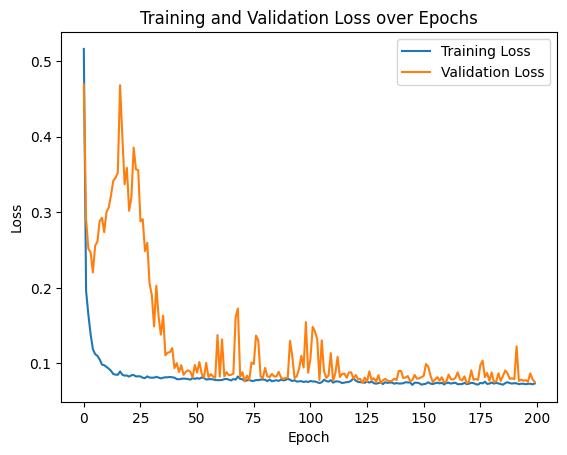

In [ ]:



#Build Model --> instantiate the weights of the defined architecture according to the choosen mode

initialize_weights(model)

#model.compile --> define loss, optimizer and metrics to be used during training

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-8, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])


# Train the model using the generator and callbacks
# Train the model using the generators and callbacks
history = model.fit(
    train_generator,
    epochs=200,
    steps_per_epoch=len(train_images)//8,
    validation_data= (val_images,val_labels),
    callbacks=[cb],
)

#add a new path to the segmented model
segm_model_path = os.path.join(segm_model_folder_path, 'segm_model.h5_1')
# Save the trained model to a file
model.save(segm_model_path)

# Plot the training and validation history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()




# Test Segmentatation Algorithm

In [ ]:
model_path = 'best_model_weights.h5'  # Update this path
model = tf.keras.models.load_model(model_path, compile=False)


NameError: ignored

In [ ]:
from sklearn.metrics import recall_score, f1_score, precision_score
import pandas as pd
# Load your trained model
model = tf.keras.models.load_model(segm_model_path, compile= False)

# Prediction
predictions = model.predict(test_images)





# Afficher les indices

threshold = 0.5
binary_map_test = (predictions >= threshold).astype(np.uint8)


#Flatten predictions and true labels for metrics calculation
flat_predictions = binary_map_test.flatten()
flat_true_labels = test_labels.flatten()


# Calculate metrics
recall = recall_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)

# Calculate Dice coefficient
dice = 2 * (precision * recall) / (precision + recall)

# Display metrics in a table using pandas
metrics_table = pd.DataFrame({
    'Metric': ['Recall', 'Precision', 'Dice Score'],
    'Value': [recall, precision, dice]
})

print(metrics_table)


1/1 [==============================] - 0s 333ms/step
       Metric     Value
0      Recall  0.716540
1   Precision  0.815507
2  Dice Score  0.762827


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



# Display each pair of original and binary mask
fig, axs = plt.subplots(binary_map_test.shape[0], 3, figsize=(30, 100))

for i in range(binary_map_test.shape[0]):
    # Plot original image
    axs[i, 0].imshow(test_images[i,:,:], cmap='gray')
    axs[i, 0].set_title(f'Original Image {i + 1}')
    axs[i, 0].axis('off')

    # Plot binary mask
    axs[i, 1].imshow(binary_map_test[i, :, :], cmap='gray')
    axs[i, 1].set_title(f'Prediction - Image {i + 1}')
    axs[i, 1].axis('off')


        # Plot binary mask
    axs[i, 2].imshow(test_labels[i, :, :], cmap='gray')
    axs[i, 2].set_title(f'Capillaries Binary Mask - Image {i + 1}')
    axs[i, 2].axis('off')

plt.show()


NameError: ignored